# Capstone Project: Neuroblastoma gene expression data analysis
## Advanced Python for Life Sciences @ Physalia courses (Summer 2025)
### Marco Chierici, Fondazione Bruno Kessler - Data Science For Health

## Objective

In this project, you will go through the analytical steps of a typical data science workflow in Python on a real-world dataset of biological relevance. The full dataset consists of gene expression values of a cohort of 498 neuroblastoma patients with associated clinical data: see the [publication](https://www.ncbi.nlm.nih.gov/pubmed/26109056) for more detailed information.

The data are publicly available on NCBI Gene Expression Omnibus: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE49711

In this study, gene expression was derived by different methods: you will work with the data table named `GSE49711_SEQC_NB_MAV_G_log2.20121127.txt.gz`.

You main goal is to investigate the relationship between gene expression and the survival status of neuroblastoma patients.

<img src="zhang_cover.png" width="65%" />

## Overview

The clinical information includes a number of variables that can be used as targets ("endpoints") in order to study the relationship between gene expression and these outcomes. Such endpoints include the "overall survival" (whether the patient was alive at the end of the follow-up), an extreme disease outcome (favorable vs. unfavorable), and the neuroblastoma risk stratification by the Children’s Oncology Group (high vs. low).

Additional clinical information include the status of the MYCN proto-oncogene genomic amplification and the tumor stage.

The staging is defined by the International Neuroblastoma Staging System and ranges from spontaneous regression (stage 4S) to gradual maturation (stages 1 − 2) to aggressive and often fatal ganglioneuroma (stages 3 − 4).

The following tables summarize the clinical information of the cohort.

<img src="zhang_table1.png" width="34%" />

<img src="zhang_table2.png" width="95%" />

## Data exploration

The log-normalized gene expression data is in the text file named `GSE49711_SEQC_NB_MAV_G_log2.20121127.txt.gz`, available on the study's GEO page. 

The clinical information for all patients ("phenotype data") is stored in the SOFT-formatted file available on GEO.

Download data and metadata from GEO using Python and import them into a Pandas dataframe.

Inspect the expression dataframe. In particular, look at the gene symbols and IDs: for the downstream analysis, keep only the genes that have a NCBI Gene ID and a RefSeq transcript ID.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you are curious about the genes with strange names without NCBI/RefSeq IDs, those are from AceView, a curated and comprehensive annotation database: more information on its <a href="https://www.ncbi.nlm.nih.gov/IEB/Research/Acembly/">website</a>.</p>
</div>

Check for duplicated gene names (column `#Gene`) and remove them (hint: the method `.duplicated()` returns True/False on duplicated elements of a column).

Check for missing *numerical* values in any column of the expression dataframe (`isnan()`) and, if any, handle them accordingly (hint: Pandas `dropna()`).

Inspect the phenotype dataframe. Retain only the columns `title` (with patient IDs) and those matching `characteristics_ch1*`. Optionally, rename them to shorter but informative names of your choice.

Focus only on a subset of the 498 patients with the label "1" in the `dataset` column of the phenotype dataframe (they should be 249). Check for missing *numerical* values in this new subset, and, if any, handle them accordingly. 

Finally, join the phenotype and expression dataframes. You can use a Pandas `merge` for this operation.

Get some basic statistics out of the data. For example, the number or proportion of patients belonging to each level of the categorical clinical variables, such as "class label", "death from disease", and "mycn status" (hint: `.value_counts()`).

Create barplots of the patient counts for each level of the clinical variables to visually check the patient distribution.

Plot the distribution (histogram, density plot) of a few genes, such as MYCN, CD3E, CD274 - globally and stratified by stage, sex, class label, death from disease, low/high risk.

Create a scatterplot matrix (e.g., `sns.pairplot()`) of genes such as GZMH, GZMK, CTLA4, TIGIT, LAMP3, BTLA, KLRK1, KLRC2, CD274. These genes are related to T-cell activity (GZMK, CTLA4, and TIGIT), control the function of intratumoral DCs (LAMP3, BTLA) and NK cells (KLRK1 and KLRC2), while CD274 is a gene encoding immune checkpoints.

Create two versions of the scatterplot matrix where you highlight the status of MYCN amplification and the favorable status.

You are also free to explore other genes or gene combinations.

## (optional) Gene pre-filtering

Filter the genes so to retain only the most variable ones, i.e. those whose standard deviation is above a predetermined threshold. Remember, choosing the right threshold is critical: you can pick a conservative threshold (keeping more genes) or a more stringent one (keeping less genes). You can check a histogram of the gene standard deviations to decide on a reasonable value. Compute the number of "surviving" genes for a few values of the threshold, then pick one.

Save the filtered dataframe to a new file.

## Statistical analysis

1. Conduct statistical tests to determine if the differences in gene expression are significant between different patient groups (`death_from_disease` condition).
3. Adjust the p-values for multiple testing
4. (optional) compute the (log) fold changes for each gene as `mean(gene expr on condition2) - mean(gene expr on condition1)` (gene expressions are already on the log scale)
5. Pick the top 10-ish genes with the lower p-values
6. Make boxplots for them, breaking down by "death_from_disease" values

## Machine learning analysis

1. Pick `death_from_disease` as the target variable
2. Split the data into training/test partitions, using for example 70/30% proportions
3. Perform a PCA on the training test with 10 components, print the explained variance ratioes, and create a scatterplot of the first two principal components, colouring the points according to the target variable
4. Build one or more classification models to predict the target variable based on gene expressions
5. Evaluate the model(s) using appropriate metrics (e.g. accuracy, precision, recall, MCC)

## Interpretation

1. If the classification model natively ranks the genes, get the top 10-ish ranked genes, otherwise get them from the results of your statistical analysis.
2. Make boxplots for them, breaking down by "death_from_disease" values
3. Use the top 100 ranked genes to conduct a pathway enrichment analysis.

Hints: trained `RandomForestClassifier` objects have a `.feature_importances_` attribute that you can use to rank the features; trained `SVC` objects (with `kernel="linear"` only) have a `.coef_` attribute with similar meaning.

## Wrap up

Finally, try to touch up your notebook as if it were a report. Jupyter notebook are actually a useful tool to create dynamic reports including text, code, and figures.

---

# One possible solution

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from ftplib import FTP
import GEOparse

In [2]:
ACCESSION = "GSE49711"
PREFIX = ACCESSION[:-3]
FTP_HOST = "ftp.ncbi.nlm.nih.gov"
FTP_PATH = f"geo/series/{PREFIX}nnn/{ACCESSION}/suppl"

DATADIR = Path("data")

gse = GEOparse.get_GEO(
    geo=ACCESSION,
    destdir=DATADIR,
    silent=True,
)

In [3]:
ftp = FTP(FTP_HOST)
ftp.login()
ftp.cwd(FTP_PATH)

'250 CWD command successful'

In [4]:
suppl_files = ftp.nlst()

In [5]:
print(f"Available supplementary files for accession {ACCESSION}:")

for fn in suppl_files:
    print(" ", fn)

Available supplementary files for accession GSE49711:
  GSE49711_SEQC_NB_MAV_G_log2.20121127.txt.gz
  GSE49711_SEQC_NB_MAV_J_log2.20121127.txt.gz
  GSE49711_SEQC_NB_MAV_README_20121202.txt
  GSE49711_SEQC_NB_MAV_README_20121211.txt
  GSE49711_SEQC_NB_MAV_README_20130212.txt
  GSE49711_SEQC_NB_MAV_T_log2.20121127.txt.gz
  GSE49711_SEQC_NB_MAV_Th_log2.20121210.txt.gz
  GSE49711_SEQC_NB_TAV_G_log2.final.txt.gz
  GSE49711_SEQC_NB_TAV_J_log2.20121201.txt.gz
  GSE49711_SEQC_NB_TAV_ReadMe.final.txt
  GSE49711_SEQC_NB_TAV_T_log2.final.txt.gz
  GSE49711_SEQC_NB_TUC_G_log2.txt.gz
  GSE49711_SEQC_NB_TUC_J_log2.txt.gz
  GSE49711_SEQC_NB_TUC_README.txt
  GSE49711_SEQC_NB_TUC_T_log2.txt.gz


In [6]:
file_of_interest = suppl_files[0]
local_filename = DATADIR / file_of_interest

In [ ]:
with open(local_filename, "wb") as fout:
    ftp.retrbinary(f"RETR {file_of_interest}", fout.write)

ftp.quit()

In [8]:
local_filename="/home/gracie/Downloads/day4-20250702T073025Z-1-001/data/GSE49711_SEQC_NB_MAV_G_log2.20121127.txt"
df_raw = pd.read_csv(local_filename, sep="\t", low_memory=False)

In [11]:
df_raw.head(4)

,#Gene,#NCBI GeneId,#RefSeq transcript Id,#Chromosome,#Strand,#from base,#to base,#Title,#Measured object,SEQC_NB001,...,SEQC_NB489,SEQC_NB490,SEQC_NB491,SEQC_NB492,SEQC_NB493,SEQC_NB494,SEQC_NB495,SEQC_NB496,SEQC_NB497,SEQC_NB498
0,ALB,213,NM_000477.5,4,+,74249329,74287139,"complex locus ALB, encoding albumin.",ALB:Gene_AceView,9.29,...,9.89,6.48,7.73,9.02,8.47,7.78,8.58,8.41,8.62,10.20
1,CD24L4.1,938;100133941,NM_013230.2,Y,-,21152409,21154677,"gene CD24L4.1, encoding CD24 molecule-like 4 p...",CD24L4.1:Gene_AceView,18.82,...,19.99,20.17,18.94,20.42,20.75,20.86,20.57,21.04,20.13,20.02
2,RPS11,6205,NM_001015.4,19,+,49999634,50002944,ribosomal protein S11,RPS11:Gene_RefSeq,21.17,...,22.98,23.31,21.14,22.85,20.08,20.91,20.67,21.10,21.04,20.82
3,RPS18,6222,NM_022551.2,6,+,33239799,33244290,"gene RPS18, encoding ribosomal protein S18.",RPS18:Gene_AceView,20.90,...,22.28,22.87,20.93,22.39,20.71,20.95,21.03,21.66,20.49,21.11


In [109]:
df_raw.tail()

,#Gene,#NCBI GeneId,#RefSeq transcript Id,#Chromosome,#Strand,#from base,#to base,#Title,#Measured object,SEQC_NB001,...,SEQC_NB489,SEQC_NB490,SEQC_NB491,SEQC_NB492,SEQC_NB493,SEQC_NB494,SEQC_NB495,SEQC_NB496,SEQC_NB497,SEQC_NB498
60773,zyjee,NaN,NaN,6,-,57400751,57416088,spliced non-coding gene zyjee.,zyjee:Gene_AceView,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.24
60774,zyler,NaN,NaN,1,+,20569588,20571150,spliced coding gene zyler.,zyler:Gene_AceView,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
60775,zymo,NaN,NaN,10,+,36727544,36731324,spliced non-coding gene zymo.,zymo:Gene_AceView,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
60776,zyswerby,NaN,NaN,3,-,9640088,9641319,spliced coding gene zyswerby.,zyswerby:Gene_AceView,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
60777,zyverbo,NaN,NaN,2,+,83299150,83301401,spliced non-coding gene zyverbo.,zyverbo:Gene_AceView,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


In [12]:
meta_df = gse.phenotype_data
meta_df

,title,geo_accession,status,submission_date,last_update_date,type,channel_count,source_name_ch1,organism_ch1,taxid_ch1,...,contact_zip/postal_code,contact_country,instrument_model,library_selection,library_source,library_strategy,relation,supplementary_file_1,series_id,data_row_count
GSM1205736,SEQC_NB001,GSM1205736,Public on May 22 2015,Aug 09 2013,May 22 2015,SRA,1,neuroblastoma,Homo sapiens,9606,...,200438,China,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,"GSE47792,GSE49711",0
GSM1205737,SEQC_NB002,GSM1205737,Public on May 22 2015,Aug 09 2013,May 22 2015,SRA,1,neuroblastoma,Homo sapiens,9606,...,200438,China,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,"GSE47792,GSE49711",0
GSM1205738,SEQC_NB003,GSM1205738,Public on May 22 2015,Aug 09 2013,May 22 2015,SRA,1,neuroblastoma,Homo sapiens,9606,...,200438,China,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,"GSE47792,GSE49711",0
GSM1205739,SEQC_NB004,GSM1205739,Public on May 22 2015,Aug 09 2013,May 22 2015,SRA,1,neuroblastoma,Homo sapiens,9606,...,200438,China,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,"GSE47792,GSE49711",0
GSM1205740,SEQC_NB005,GSM1205740,Public on May 22 2015,Aug 09 2013,May 22 2015,SRA,1,neuroblastoma,Homo sapiens,9606,...,200438,China,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,"GSE47792,GSE49711",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1206229,SEQC_NB494,GSM1206229,Public on May 22 2015,Aug 09 2013,May 22 2015,SRA,1,neuroblastoma,Homo sapiens,9606,...,200438,China,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,"GSE47792,GSE49711",0
GSM1206230,SEQC_NB495,GSM1206230,Public on May 22 2015,Aug 09 2013,May 22 2015,SRA,1,neuroblastoma,Homo sapiens,9606,...,200438,China,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,"GSE47792,GSE49711",0
GSM1206231,SEQC_NB496,GSM1206231,Public on May 22 2015,Aug 09 2013,May 22 2015,SRA,1,neuroblastoma,Homo sapiens,9606,...,200438,China,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,"GSE47792,GSE49711",0
GSM1206232,SEQC_NB497,GSM1206232,Public on May 22 2015,Aug 09 2013,May 22 2015,SRA,1,neuroblastoma,Homo sapiens,9606,...,200438,China,Illumina HiSeq 2000,cDNA,transcriptomic,RNA-Seq,BioSample: https://www.ncbi.nlm.nih.gov/biosam...,NONE,"GSE47792,GSE49711",0


In [13]:
meta_df.columns

Index(['title', 'geo_accession', 'status', 'submission_date',
       'last_update_date', 'type', 'channel_count', 'source_name_ch1',
       'organism_ch1', 'taxid_ch1', 'characteristics_ch1.0.tissue',
       'characteristics_ch1.1.dataset', 'characteristics_ch1.2.Sex',
       'characteristics_ch1.3.age at diagnosis',
       'characteristics_ch1.4.mycn status', 'characteristics_ch1.5.high risk',
       'characteristics_ch1.6.inss stage', 'characteristics_ch1.7.class label',
       'characteristics_ch1.8.progression',
       'characteristics_ch1.9.death from disease', 'treatment_protocol_ch1',
       'growth_protocol_ch1', 'molecule_ch1', 'extract_protocol_ch1',
       'data_processing', 'platform_id', 'contact_name', 'contact_email',
       'contact_phone', 'contact_laboratory', 'contact_department',
       'contact_institute', 'contact_address', 'contact_city',
       'contact_zip/postal_code', 'contact_country', 'instrument_model',
       'library_selection', 'library_source', 'librar

In [14]:
# optionally, drop columns
meta_cols_to_keep = meta_df.columns[(meta_df.columns == 'title') | (meta_df.columns.str.startswith('characteristics'))]
meta_df = meta_df[meta_cols_to_keep]
meta_df.head(4)

,title,characteristics_ch1.0.tissue,characteristics_ch1.1.dataset,characteristics_ch1.2.Sex,characteristics_ch1.3.age at diagnosis,characteristics_ch1.4.mycn status,characteristics_ch1.5.high risk,characteristics_ch1.6.inss stage,characteristics_ch1.7.class label,characteristics_ch1.8.progression,characteristics_ch1.9.death from disease
GSM1205736,SEQC_NB001,neuroblastoma,1,M,987,0,1,4,1,1,1
GSM1205737,SEQC_NB002,neuroblastoma,2,M,1808,0,1,4,1,1,1
GSM1205738,SEQC_NB003,neuroblastoma,1,F,625,1,1,4,1,1,1
GSM1205739,SEQC_NB004,neuroblastoma,2,F,335,1,1,2,N/A,0,0


In [15]:
meta_df = meta_df.drop(columns=['characteristics_ch1.0.tissue'])
meta_df.head(4)

,title,characteristics_ch1.1.dataset,characteristics_ch1.2.Sex,characteristics_ch1.3.age at diagnosis,characteristics_ch1.4.mycn status,characteristics_ch1.5.high risk,characteristics_ch1.6.inss stage,characteristics_ch1.7.class label,characteristics_ch1.8.progression,characteristics_ch1.9.death from disease
GSM1205736,SEQC_NB001,1,M,987,0,1,4,1,1,1
GSM1205737,SEQC_NB002,2,M,1808,0,1,4,1,1,1
GSM1205738,SEQC_NB003,1,F,625,1,1,4,1,1,1
GSM1205739,SEQC_NB004,2,F,335,1,1,2,N/A,0,0


In [16]:
# cleanup column names a bit
# e.g. "characteristics_ch1.3.age at diagnosis" -> "age_at_diagnosis"

newcols = meta_df.columns.str.replace(r'^.*\.', '', regex=True)
newcols

Index(['title', 'dataset', 'Sex', 'age at diagnosis', 'mycn status',
       'high risk', 'inss stage', 'class label', 'progression',
       'death from disease'],
      dtype='object')

In [17]:
newcols = newcols.str.replace(' ', '_')
meta_df.columns = newcols

In [18]:
# keep only genes with a NCBI gene ID
df = df_raw.loc[~df_raw["#NCBI GeneId"].isna() & ~df_raw['#RefSeq transcript Id'].isna()]

In [19]:
# select relevant columns from expression df before merging with sample metadata
expr = df[ df.columns[df.columns.str.contains('#Gene') | df.columns.str.startswith("SEQC_")] ].rename(columns={"#Gene": "ID"})
expr.shape

(22861, 499)

In [20]:
expr.head(4)

,ID,SEQC_NB001,SEQC_NB002,SEQC_NB003,SEQC_NB004,SEQC_NB005,SEQC_NB006,SEQC_NB007,SEQC_NB008,SEQC_NB009,...,SEQC_NB489,SEQC_NB490,SEQC_NB491,SEQC_NB492,SEQC_NB493,SEQC_NB494,SEQC_NB495,SEQC_NB496,SEQC_NB497,SEQC_NB498
0,ALB,9.29,7.99,9.25,9.35,8.99,9.26,8.15,9.54,10.72,...,9.89,6.48,7.73,9.02,8.47,7.78,8.58,8.41,8.62,10.20
1,CD24L4.1,18.82,19.80,20.25,20.44,20.09,20.38,19.75,20.21,19.66,...,19.99,20.17,18.94,20.42,20.75,20.86,20.57,21.04,20.13,20.02
2,RPS11,21.17,20.42,22.44,21.22,22.09,21.23,21.00,22.60,21.43,...,22.98,23.31,21.14,22.85,20.08,20.91,20.67,21.10,21.04,20.82
3,RPS18,20.90,20.36,22.00,21.08,21.71,20.74,20.88,22.55,21.63,...,22.28,22.87,20.93,22.39,20.71,20.95,21.03,21.66,20.49,21.11


In [21]:
# check for duplicated gene names...
expr.loc[expr.ID.duplicated(), :].shape

(187, 499)

In [120]:
# ... and remove them
expr = expr.loc[~expr.ID.duplicated(), :].copy()
expr

,ID,SEQC_NB001,SEQC_NB002,SEQC_NB003,SEQC_NB004,SEQC_NB005,SEQC_NB006,SEQC_NB007,SEQC_NB008,SEQC_NB009,...,SEQC_NB489,SEQC_NB490,SEQC_NB491,SEQC_NB492,SEQC_NB493,SEQC_NB494,SEQC_NB495,SEQC_NB496,SEQC_NB497,SEQC_NB498
0,ALB,9.29,7.99,9.25,9.35,8.99,9.26,8.15,9.54,10.72,...,9.89,6.48,7.73,9.02,8.47,7.78,8.58,8.41,8.62,10.20
1,CD24L4.1,18.82,19.80,20.25,20.44,20.09,20.38,19.75,20.21,19.66,...,19.99,20.17,18.94,20.42,20.75,20.86,20.57,21.04,20.13,20.02
2,RPS11,21.17,20.42,22.44,21.22,22.09,21.23,21.00,22.60,21.43,...,22.98,23.31,21.14,22.85,20.08,20.91,20.67,21.10,21.04,20.82
3,RPS18,20.90,20.36,22.00,21.08,21.71,20.74,20.88,22.55,21.63,...,22.28,22.87,20.93,22.39,20.71,20.95,21.03,21.66,20.49,21.11
4,C5orf13,20.02,21.70,21.05,21.89,21.65,21.14,21.48,20.64,21.81,...,21.55,21.04,20.57,21.06,22.16,21.98,21.56,21.80,22.06,21.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57174,WFDC9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57175,XAGE2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.02
57176,XAGE2B,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.02
57178,ZFATAS,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [121]:
# transpose so to have patient IDs on the rows
expr = expr.set_index('ID').T
expr

ID,ALB,CD24L4.1,RPS11,RPS18,C5orf13,CCT2,COL1A1,DDX1,EEF1A1,FLT3LG_,...,USP17L5,USP17L7,USP17L8,VTRNA2,WFDC11,WFDC9,XAGE2,XAGE2B,ZFATAS,ZP4
SEQC_NB001,9.29,18.82,21.17,20.90,20.02,16.31,18.60,15.73,21.71,20.02,...,0.0,0.0,0.00,0.0,4.74,0.0,0.00,0.00,0.0,0.0
SEQC_NB002,7.99,19.80,20.42,20.36,21.70,16.74,18.76,15.62,21.08,19.23,...,0.0,0.0,0.00,0.0,2.98,0.0,0.00,0.00,0.0,0.0
SEQC_NB003,9.25,20.25,22.44,22.00,21.05,17.06,19.39,22.84,22.72,21.26,...,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0
SEQC_NB004,9.35,20.44,21.22,21.08,21.89,16.83,20.87,15.81,22.18,20.02,...,0.0,0.0,0.00,0.0,5.14,0.0,0.00,0.00,0.0,0.0
SEQC_NB005,8.99,20.09,22.09,21.71,21.65,16.85,23.02,15.79,22.24,20.75,...,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQC_NB494,7.78,20.86,20.91,20.95,21.98,16.71,19.66,15.75,22.57,20.04,...,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0
SEQC_NB495,8.58,20.57,20.67,21.03,21.56,16.64,19.86,15.72,22.26,19.96,...,0.0,0.0,0.00,0.0,2.83,0.0,0.00,0.00,0.0,0.0
SEQC_NB496,8.41,21.04,21.10,21.66,21.80,16.96,20.37,15.89,22.78,20.17,...,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0
SEQC_NB497,8.62,20.13,21.04,20.49,22.06,16.41,19.53,15.90,22.30,20.05,...,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0


In [122]:
expr.isna().sum()

ID
ALB         0
CD24L4.1    0
RPS11       0
RPS18       0
C5orf13     0
           ..
WFDC9       0
XAGE2       0
XAGE2B      0
ZFATAS      0
ZP4         0
Length: 22674, dtype: int64

In [123]:
expr.isna().sum().sum()

np.int64(0)

In [23]:
meta_tr = meta_df.loc[meta_df.dataset == '1'].copy()
meta_tr.shape

(249, 10)

In [28]:
meta_tr.columns

Index(['title', 'dataset', 'Sex', 'age_at_diagnosis', 'mycn_status',
       'high_risk', 'inss_stage', 'class_label', 'progression',
       'death_from_disease'],
      dtype='object')

In [125]:
meta_tr["class_label"].value_counts()

class_label
N/A    113
0       91
1       45
Name: count, dtype: int64

In [24]:
meta_tr["class_label"] = meta_tr["class_label"].map({"N/A": "Neither", "0": "Favorable", "1": "Unfavorable"})
meta_tr["class_label"].value_counts()

class_label
Neither        113
Favorable       91
Unfavorable     45
Name: count, dtype: int64

In [127]:
meta_tr["death_from_disease"].value_counts()

death_from_disease
0    198
1     51
Name: count, dtype: int64

In [128]:
meta_tr["Sex"].value_counts()

Sex
M    146
F    103
Name: count, dtype: int64

In [129]:
meta_tr["inss_stage"].value_counts()

inss_stage
4     91
1     60
2     40
3     30
4S    28
Name: count, dtype: int64

In [130]:
meta_tr["mycn_status"].value_counts()

mycn_status
0      199
1       47
N/A      3
Name: count, dtype: int64

In [131]:
meta_tr["mycn_status"] = meta_tr["mycn_status"].map({"0": "Normal", "1": "Amplified"})
meta_tr["mycn_status"].value_counts()

mycn_status
Normal       199
Amplified     47
Name: count, dtype: int64

In [132]:
meta_tr.isna().sum()

title                 0
dataset               0
Sex                   0
age_at_diagnosis      0
mycn_status           3
high_risk             0
inss_stage            0
class_label           0
progression           0
death_from_disease    0
dtype: int64

In [133]:
meta_tr = meta_tr.dropna()

In [134]:
# merge metadata with expression df
expr_tr = meta_tr.merge(expr, left_on="title", right_index=True)
expr_tr.head(4)

,title,dataset,Sex,age_at_diagnosis,mycn_status,high_risk,inss_stage,class_label,progression,death_from_disease,...,USP17L5,USP17L7,USP17L8,VTRNA2,WFDC11,WFDC9,XAGE2,XAGE2B,ZFATAS,ZP4
GSM1205736,SEQC_NB001,1,M,987,Normal,1,4,Unfavorable,1,1,...,0.0,0.0,0.0,0.0,4.74,0.0,0.0,0.0,0.0,0.0
GSM1205738,SEQC_NB003,1,F,625,Amplified,1,4,Unfavorable,1,1,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
GSM1205740,SEQC_NB005,1,F,536,Amplified,1,4,Unfavorable,1,1,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
GSM1205742,SEQC_NB007,1,M,942,Normal,1,4,Neither,1,0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [135]:
expr_tr.shape

(246, 22684)

In [136]:
expr.columns

Index(['ALB', 'CD24L4.1', 'RPS11', 'RPS18', 'C5orf13', 'CCT2', 'COL1A1',
       'DDX1', 'EEF1A1', 'FLT3LG_',
       ...
       'USP17L5', 'USP17L7', 'USP17L8', 'VTRNA2', 'WFDC11', 'WFDC9', 'XAGE2',
       'XAGE2B', 'ZFATAS', 'ZP4'],
      dtype='object', name='ID', length=22674)

In [137]:
# now that the expression data is aligned with phenotype data,
# extract expression and clinical data to separate dataframes
data = expr_tr[["title"] + expr.columns.tolist()].copy()
data = data.set_index("title")
data

,ALB,CD24L4.1,RPS11,RPS18,C5orf13,CCT2,COL1A1,DDX1,EEF1A1,FLT3LG_,...,USP17L5,USP17L7,USP17L8,VTRNA2,WFDC11,WFDC9,XAGE2,XAGE2B,ZFATAS,ZP4
title,,,,,,,,,,,,,,,,,,,,,
SEQC_NB001,9.29,18.82,21.17,20.90,20.02,16.31,18.60,15.73,21.71,20.02,...,0.0,0.0,0.0,0.0,4.74,0.0,0.0,0.0,0.0,0.0
SEQC_NB003,9.25,20.25,22.44,22.00,21.05,17.06,19.39,22.84,22.72,21.26,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
SEQC_NB005,8.99,20.09,22.09,21.71,21.65,16.85,23.02,15.79,22.24,20.75,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
SEQC_NB007,8.15,19.75,21.00,20.88,21.48,16.45,20.58,16.09,22.07,20.06,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
SEQC_NB009,10.72,19.66,21.43,21.63,21.81,17.28,19.65,15.90,22.59,20.11,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQC_NB489,9.89,19.99,22.98,22.28,21.55,17.00,17.46,22.83,22.93,21.40,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
SEQC_NB491,7.73,18.94,21.14,20.93,20.57,17.08,16.94,15.81,21.73,20.20,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
SEQC_NB493,8.47,20.75,20.08,20.71,22.16,16.63,17.11,15.93,22.09,19.11,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [138]:
clin = expr_tr[meta_tr.columns].copy()
clin = clin.set_index("title")
clin

,dataset,Sex,age_at_diagnosis,mycn_status,high_risk,inss_stage,class_label,progression,death_from_disease
title,,,,,,,,,
SEQC_NB001,1,M,987,Normal,1,4,Unfavorable,1,1
SEQC_NB003,1,F,625,Amplified,1,4,Unfavorable,1,1
SEQC_NB005,1,F,536,Amplified,1,4,Unfavorable,1,1
SEQC_NB007,1,M,942,Normal,1,4,Neither,1,0
SEQC_NB009,1,F,217,Amplified,1,4S,Neither,0,0
...,...,...,...,...,...,...,...,...,...
SEQC_NB489,1,F,865,Amplified,1,4,Neither,0,0
SEQC_NB491,1,M,2326,Normal,1,4,Neither,1,0
SEQC_NB493,1,M,190,Normal,0,1,Favorable,0,0


In [ ]:
# basic data exploration
# barplots of the clinical variables to check distrib.
# exploratory plots:
# distribution (histogram) of MYCN, CD3E, CD274 (overall and stratified by stage, sex, endpoint);
# same but with boxplots
# scatterplot matrices of 
# PCA plots: overall, then colored by mycn_status, risk, stage, etc.

<Axes: xlabel='Sex'>

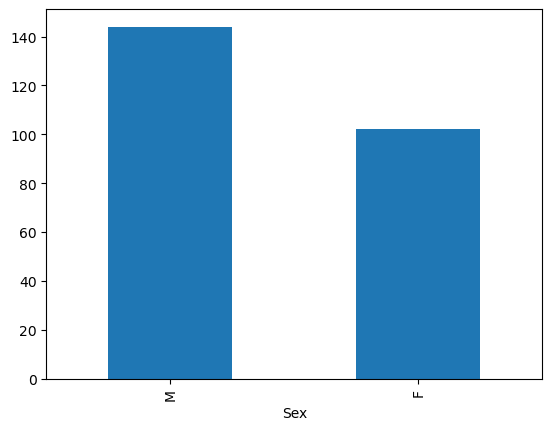

In [139]:
expr_tr["Sex"].value_counts().plot(kind="bar")

<Axes: xlabel='mycn_status'>

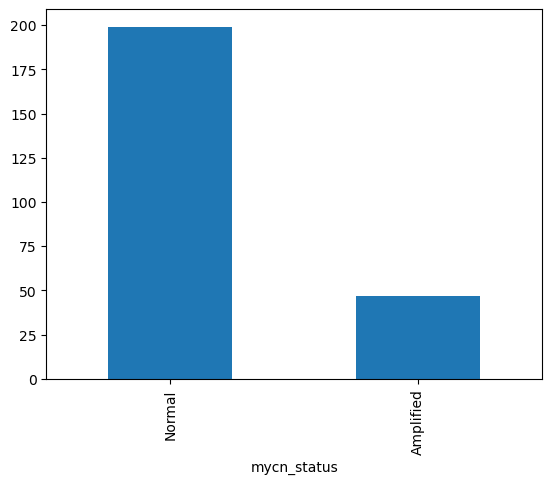

In [140]:
expr_tr["mycn_status"].value_counts().plot(kind="bar")

<Axes: xlabel='high_risk'>

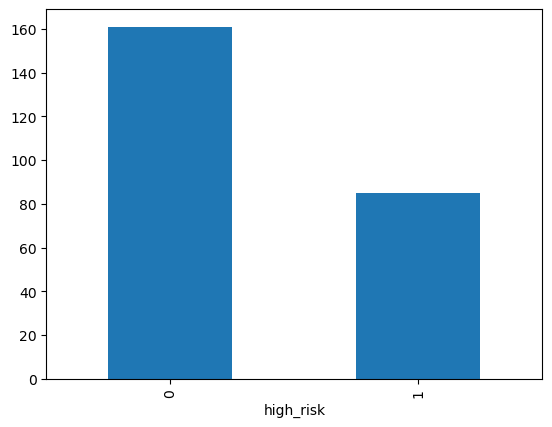

In [141]:
expr_tr["high_risk"].value_counts().plot(kind="bar")

<Axes: xlabel='inss_stage'>

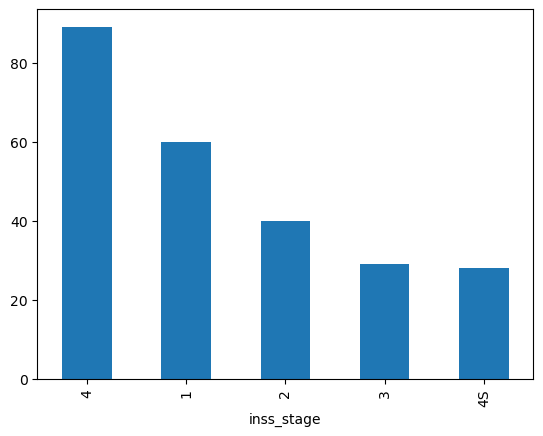

In [142]:
expr_tr["inss_stage"].value_counts().plot(kind="bar")

<Axes: xlabel='death_from_disease'>

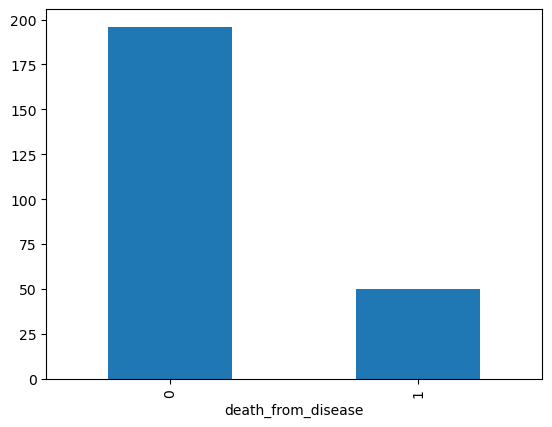

In [143]:
expr_tr["death_from_disease"].value_counts().plot(kind="bar")

<Axes: ylabel='Frequency'>

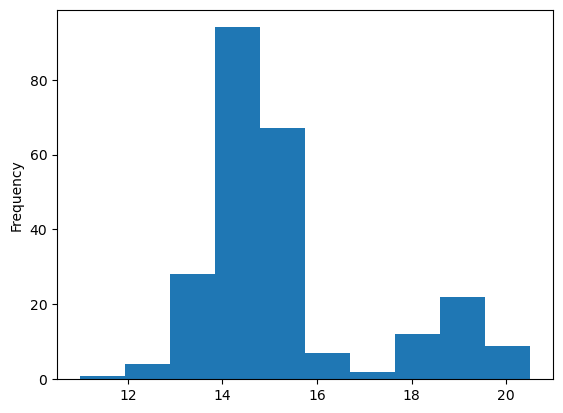

In [144]:
data["MYCN"].plot(kind="hist")

In [145]:
import seaborn as sns

<Axes: xlabel='MYCN', ylabel='Count'>

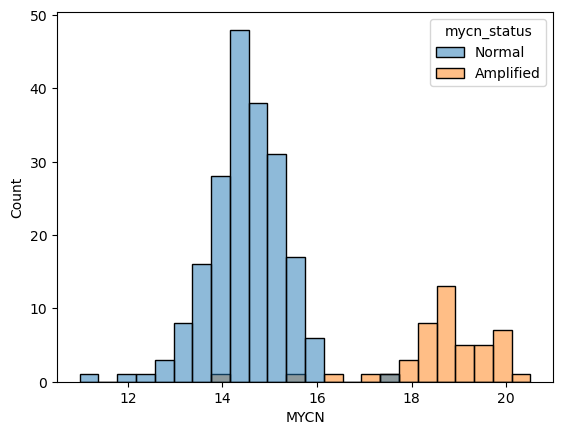

In [146]:
sns.histplot(x="MYCN", hue="mycn_status", data=expr_tr)

<Axes: xlabel='MYCN', ylabel='Density'>

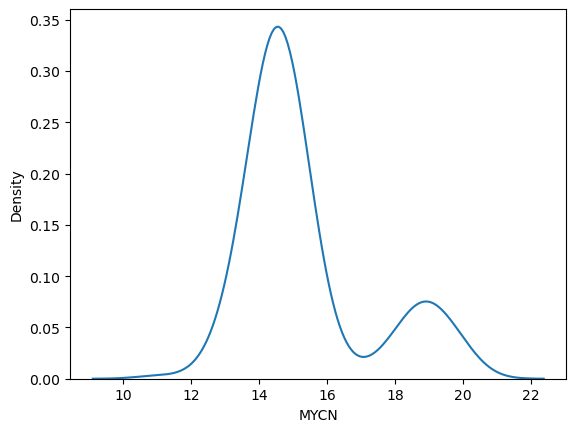

In [147]:
sns.kdeplot(x="MYCN", data=expr_tr)

<Axes: xlabel='MYCN', ylabel='Density'>

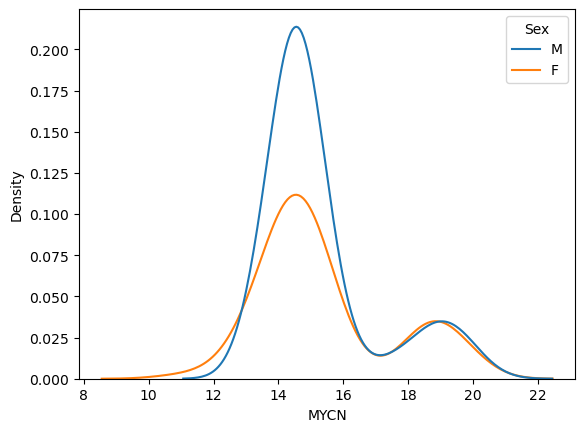

In [148]:
sns.kdeplot(x="MYCN", hue="Sex", data=expr_tr)

<Axes: xlabel='MYCN', ylabel='Density'>

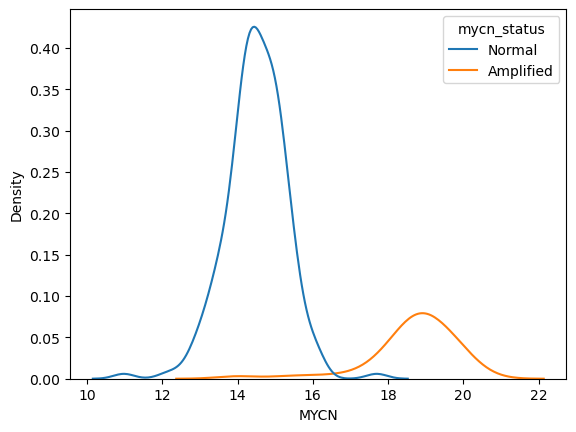

In [149]:
sns.kdeplot(x="MYCN", hue="mycn_status", data=expr_tr)

<Axes: xlabel='MYCN', ylabel='Density'>

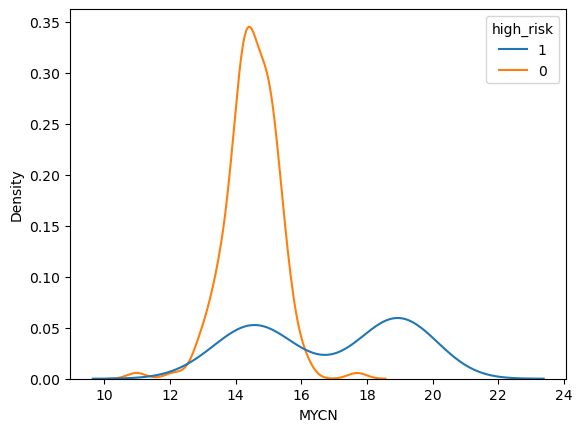

In [150]:
sns.kdeplot(x="MYCN", hue="high_risk", data=expr_tr)

<Axes: xlabel='MYCN', ylabel='Density'>

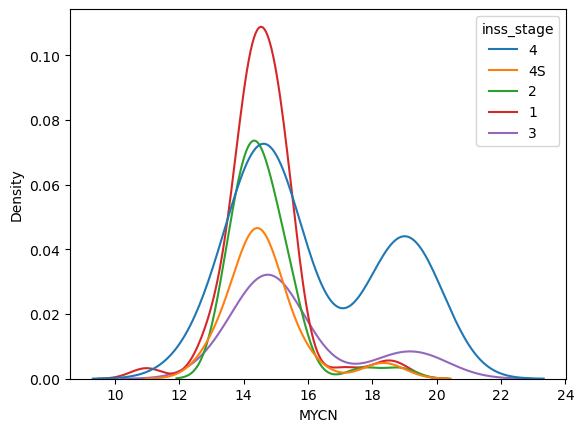

In [151]:
sns.kdeplot(x="MYCN", hue="inss_stage", data=expr_tr)

<Axes: xlabel='MYCN', ylabel='Density'>

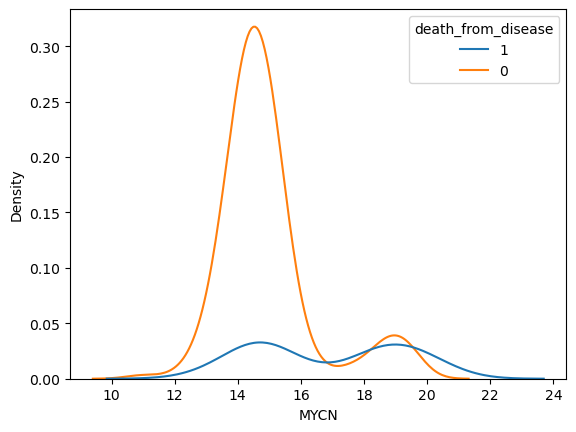

In [152]:
sns.kdeplot(x="MYCN", hue="death_from_disease", data=expr_tr)

<Axes: xlabel='CD3E', ylabel='Density'>

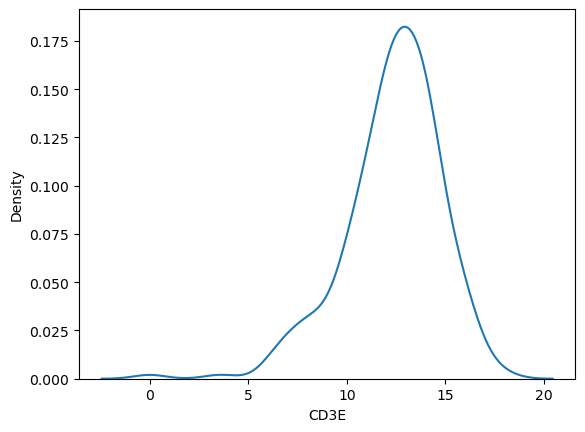

In [153]:
sns.kdeplot(x="CD3E", data=expr_tr)

<Axes: xlabel='CD3E', ylabel='Density'>

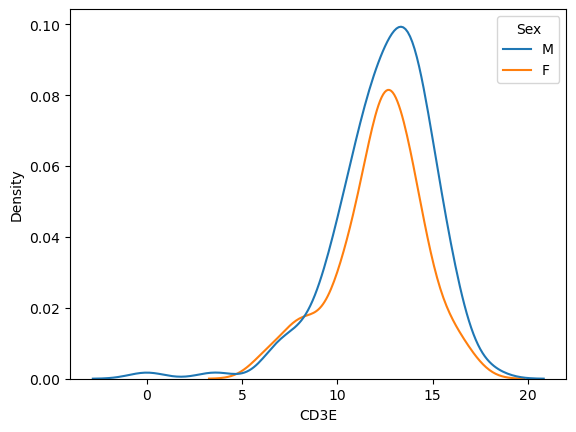

In [154]:
sns.kdeplot(x="CD3E", hue="Sex", data=expr_tr)

<Axes: xlabel='CD3E', ylabel='Density'>

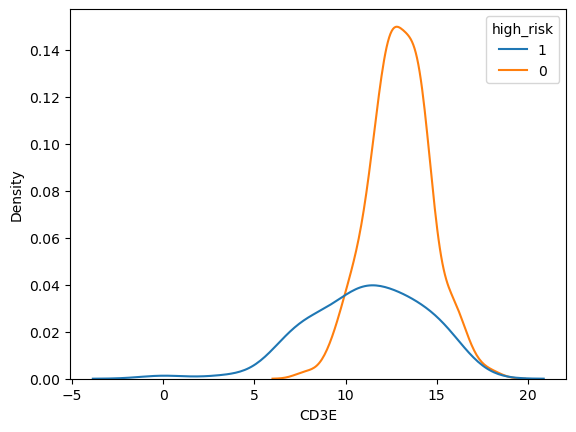

In [155]:
sns.kdeplot(x="CD3E", hue="high_risk", data=expr_tr)

<Axes: xlabel='high_risk', ylabel='CD3E'>

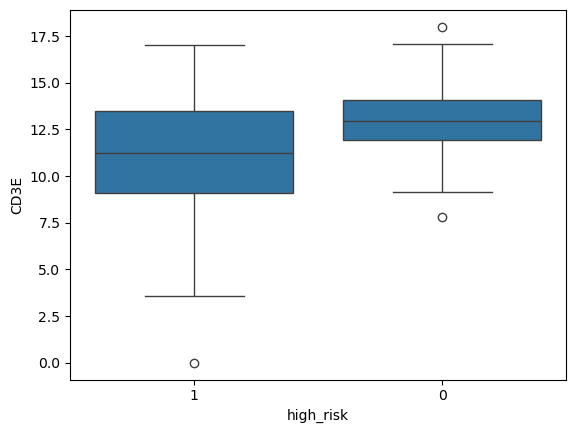

In [156]:
sns.boxplot(y="CD3E", x="high_risk", data=expr_tr)

<Axes: xlabel='CD3E', ylabel='Density'>

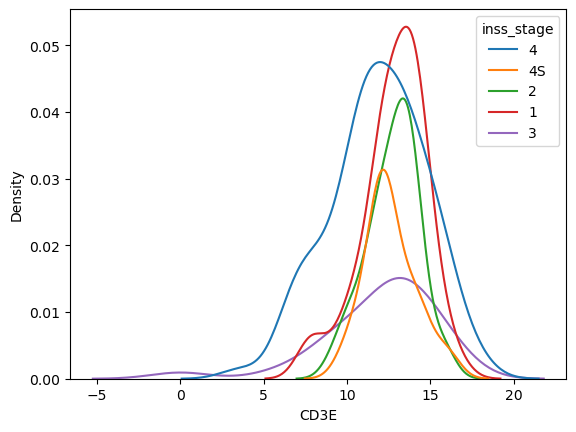

In [157]:
sns.kdeplot(x="CD3E", hue="inss_stage", data=expr_tr)

<Axes: xlabel='CD3E', ylabel='Density'>

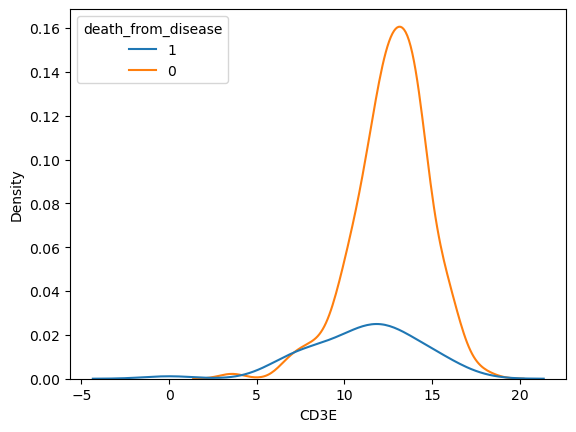

In [158]:
sns.kdeplot(x="CD3E", hue="death_from_disease", data=expr_tr)

In [ ]:
sns.boxplot(x="death_from_disease", y="CD3E", data=expr_tr)

In [ ]:
sns.kdeplot(x="CD274", data=expr_tr)

In [ ]:
sns.kdeplot(x="CD274", hue="Sex", data=expr_tr)

In [ ]:
sns.kdeplot(x="CD274", hue="inss_stage", data=expr_tr)

In [ ]:
sns.kdeplot(x="CD274", hue="death_from_disease", data=expr_tr)

In [ ]:
sns.boxplot(x="death_from_disease", y="CD274", data=expr_tr)

In [159]:
genes = ["GZMH", "GZMK", "CTLA4", "TIGIT", "LAMP3", "BTLA", "KLRK1", "KLRC2", "CD274"]

df_for_plot = expr_tr.loc[:, genes]
df_for_plot

,GZMH,GZMK,CTLA4,TIGIT,LAMP3,BTLA,KLRK1,KLRC2,CD274
GSM1205736,8.99,11.74,9.95,10.97,11.99,12.58,13.80,6.03,10.84
GSM1205738,3.50,6.68,0.00,6.50,7.51,0.00,6.97,0.00,7.64
GSM1205740,7.43,8.54,0.00,6.29,6.61,0.00,6.99,0.00,8.38
GSM1205742,13.20,14.22,11.20,12.26,11.35,10.60,14.90,11.09,11.26
GSM1205744,7.81,8.23,8.92,8.78,9.16,6.37,9.96,4.95,8.58
...,...,...,...,...,...,...,...,...,...
GSM1206224,0.00,4.72,0.00,0.00,7.59,0.00,8.45,0.00,7.62
GSM1206226,11.92,12.50,10.57,11.63,9.76,9.16,13.60,10.72,11.77
GSM1206228,4.42,3.57,6.28,6.10,7.64,5.80,9.20,5.29,9.09
GSM1206230,8.91,10.18,10.53,8.90,11.00,9.22,12.46,7.90,10.81


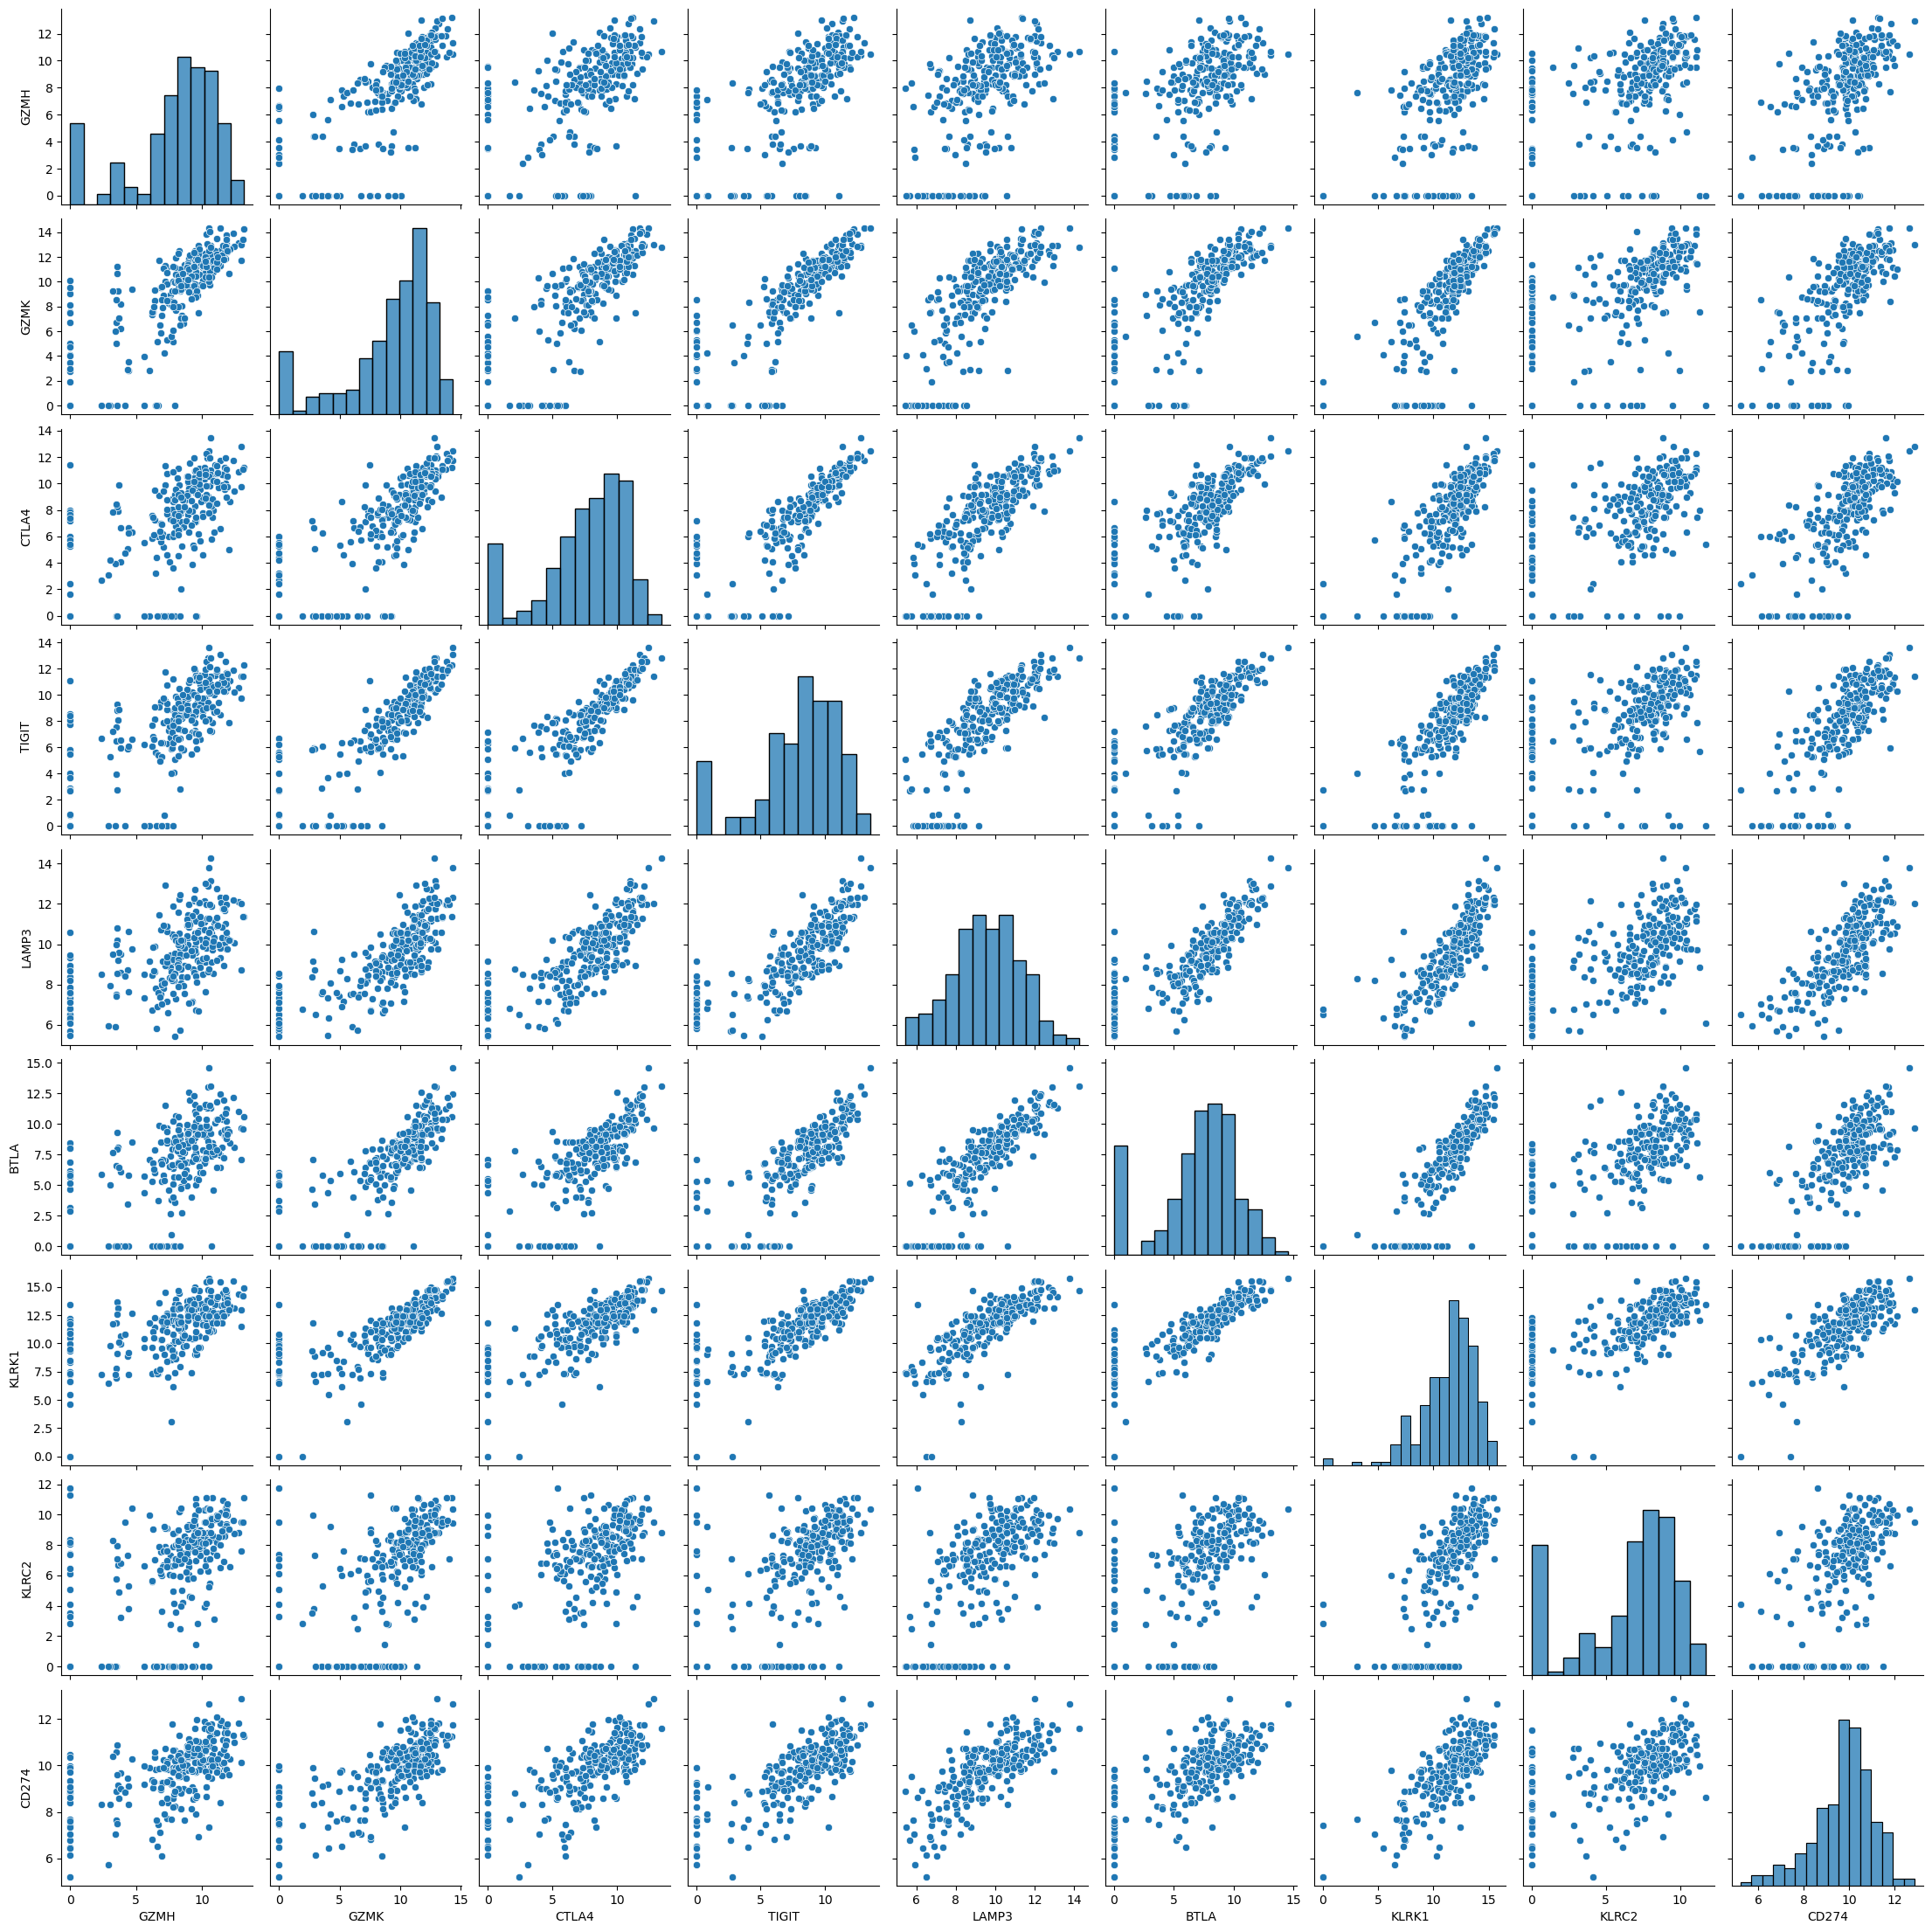

In [160]:
sns.pairplot(df_for_plot)

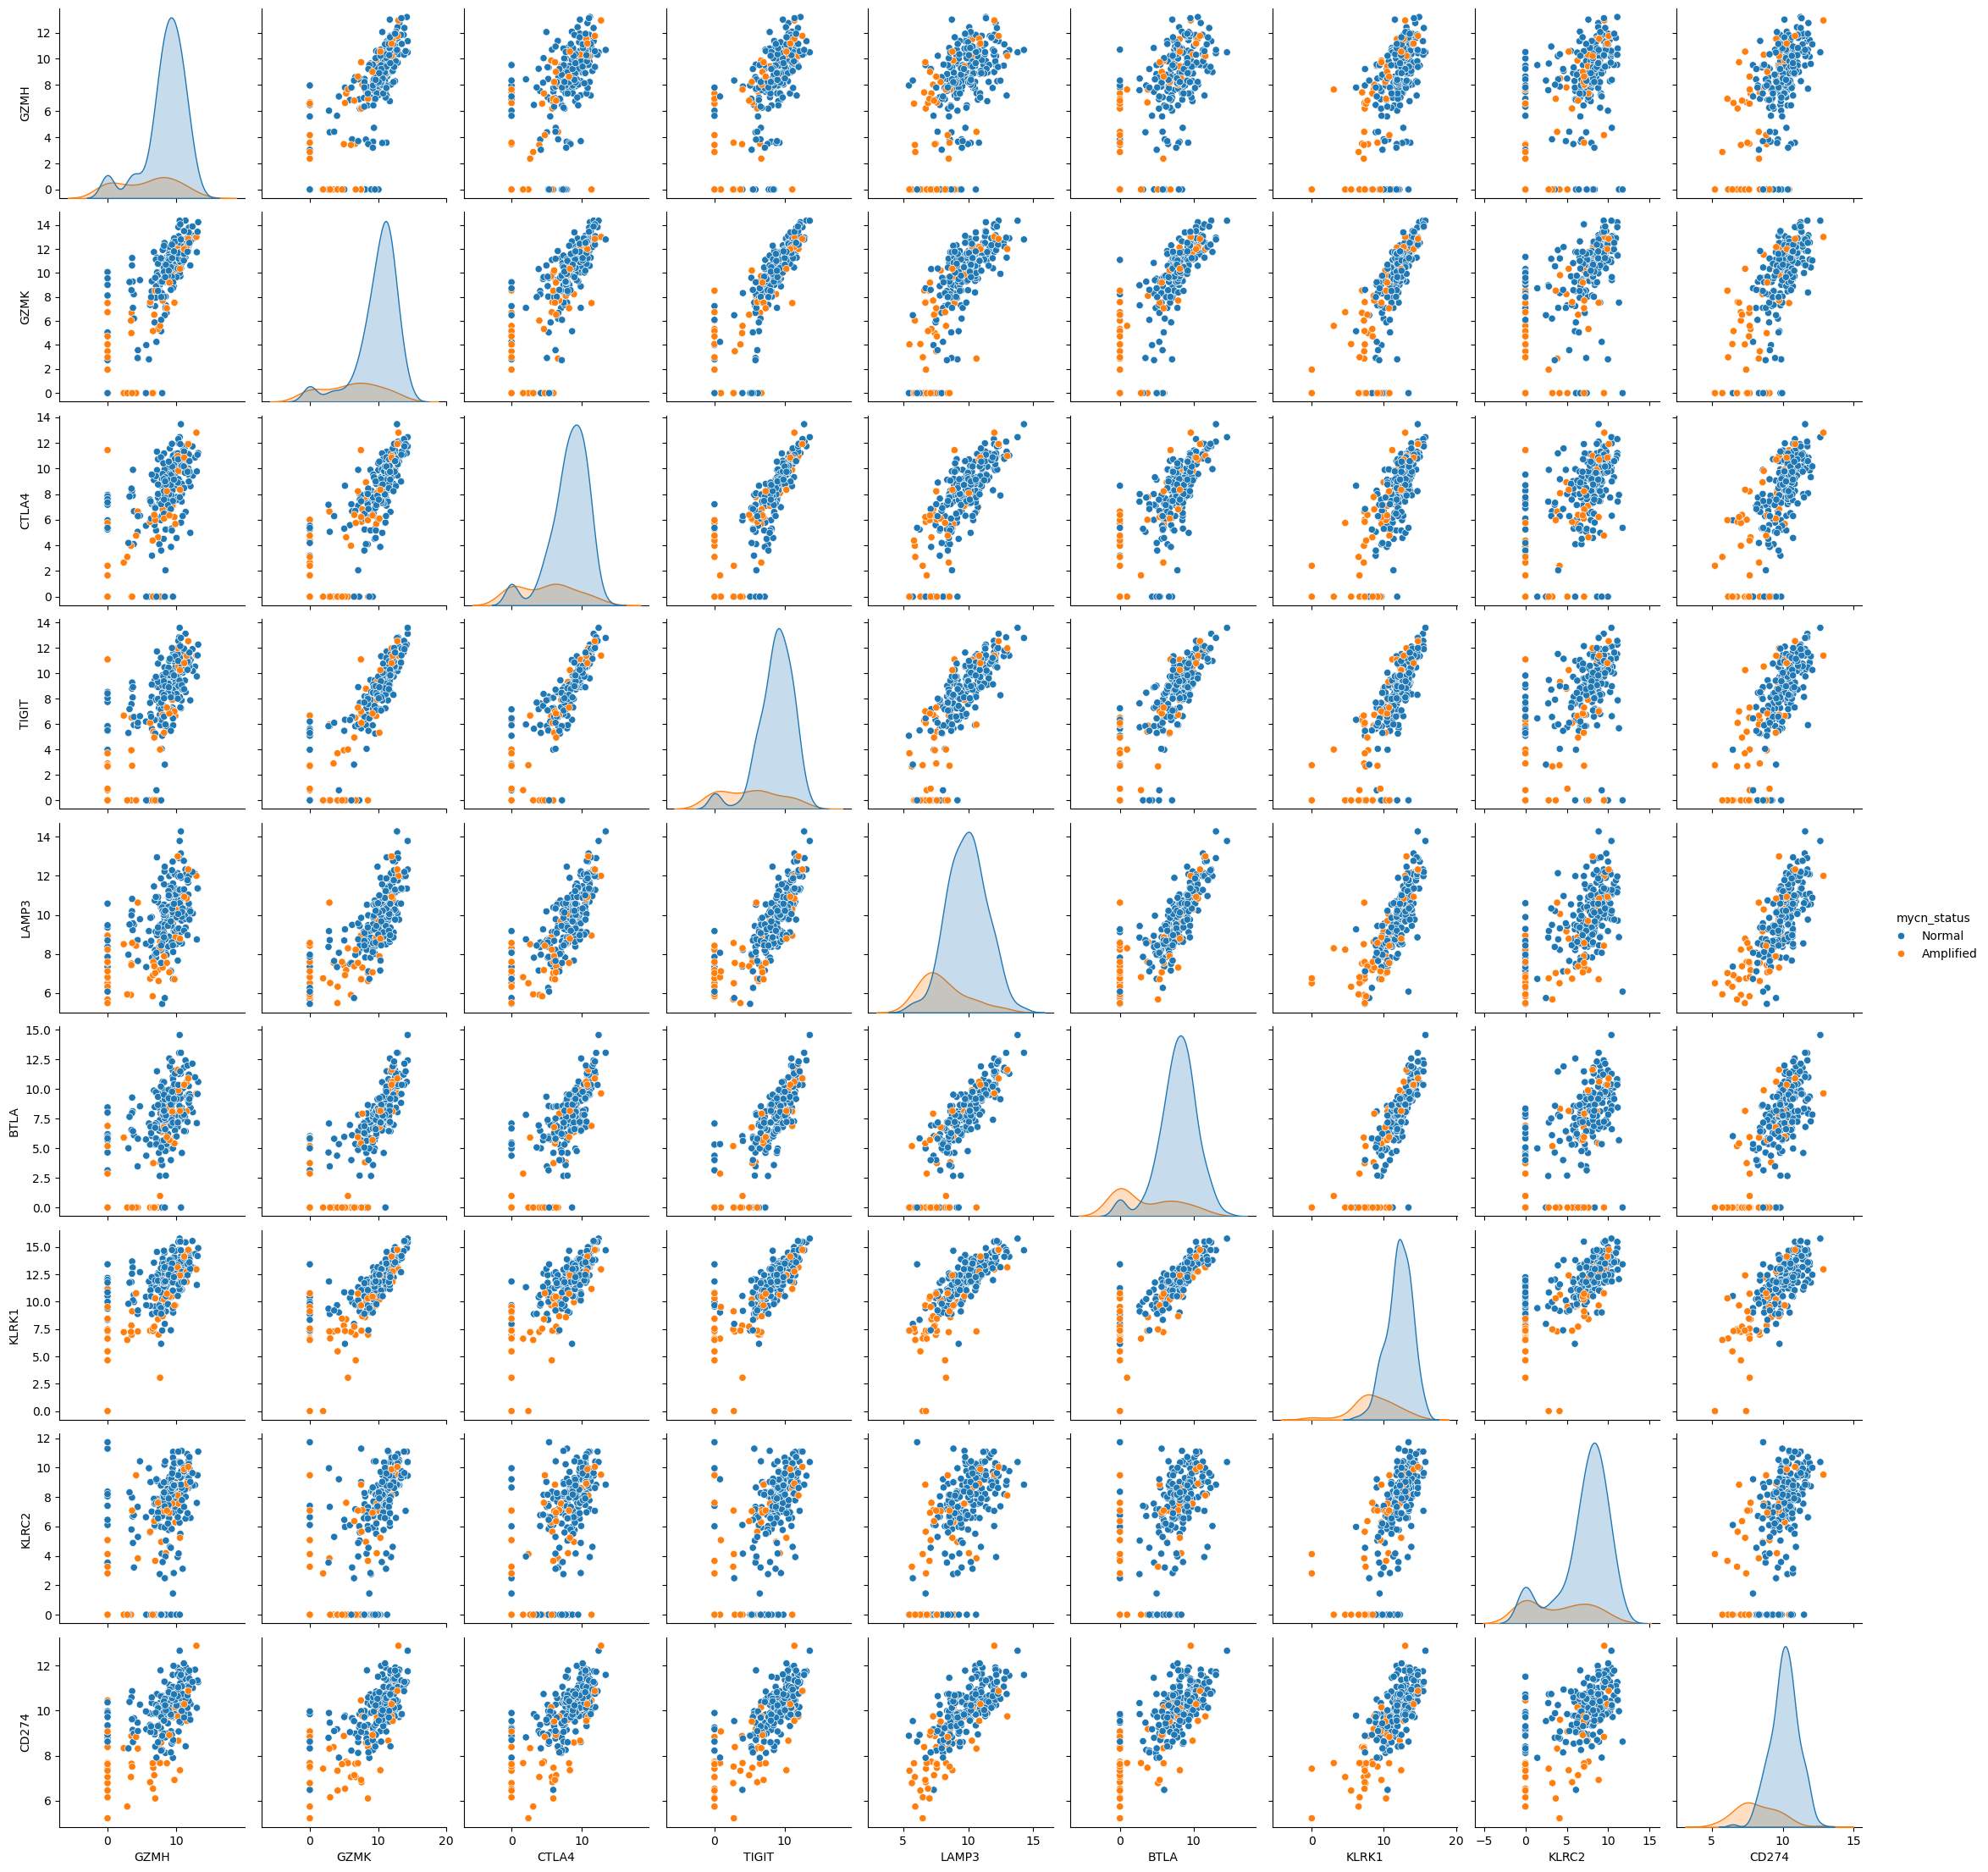

In [161]:
df_for_plot = expr_tr.loc[:, ['mycn_status'] + genes]

sns.pairplot(df_for_plot, hue="mycn_status")

<Axes: ylabel='Frequency'>

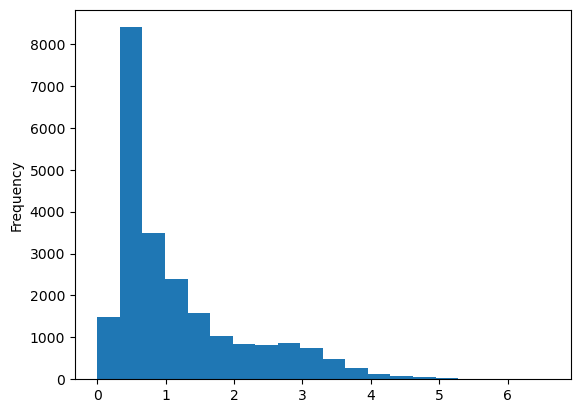

In [162]:
# gene prefiltering: keep genes above a fixed standard deviation threshold
# remember, choosing the right stdev threshold is critical
# check a histogram of stdev to decide on a reasonable value
# you can pick a conservative threshold (keeping more genes) or a more stringent one (keeping less genes)
# compute the number of "surviving" genes for a few values of the threshold, then pick one
data.std().plot(kind="hist", bins=20)

In [163]:
data.shape

(246, 22674)

In [164]:
data.loc[:, data.std() > 0.9].shape

(246, 10108)

In [165]:
data_flt = data.loc[:, data.std() > 0.9].copy()

In [ ]:
# statistical analysis
# pick the variable "death_from_disease" as the condition
# assess statistical significance with a statistical test (for each gene)
# adjust the p-values for multiple testing
# (optional) compute the (log) fold changes for each gene:
# - mean of gene expr on condition2 - mean of gene expr on condition1 (gene exprs are already log)
# pick the top 10-ish genes with the lower p-values
# make boxplots for them, breaking down by "death_from_disease" values

In [166]:
from scipy import stats

grp1 = data_flt[clin['death_from_disease'] == '0']
grp2 = data_flt[clin['death_from_disease'] == '1']

adjust = True

# empty list that will store the p-values for each gene
p_vals = []

# gene names
genes = data_flt.columns

for gene in genes:
    _, p = stats.mannwhitneyu(grp1[gene], grp2[gene])
    p_vals.append(p)

results = pd.DataFrame({'Gene': genes,
                        'p-value': p_vals})

In [167]:
data_flt.columns.duplicated().sum()

np.int64(0)

In [168]:
from statsmodels.stats.multitest import multipletests

adj_p = multipletests(np.array(p_vals), alpha=0.05, method="fdr_bh")[1]
results["Adjusted p-value"] = adj_p

In [169]:
results_srt = results.sort_values(by="Adjusted p-value")
results_srt

,Gene,p-value,Adjusted p-value
5255,LOC283177,4.163882e-16,4.208851e-12
567,WSB1,3.249105e-15,7.572304e-12
934,MAD2L1,1.951901e-15,7.572304e-12
980,NRBP2,5.243978e-15,7.572304e-12
1372,CES8,4.353212e-15,7.572304e-12
...,...,...,...
9318,HIST1H1A,1.000000e+00,1.000000e+00
334,COTL1,1.000000e+00,1.000000e+00
1490,ESRRG,1.000000e+00,1.000000e+00
1746,LOC100289087,1.000000e+00,1.000000e+00


<Axes: xlabel='death_from_disease', ylabel='LOC283177'>

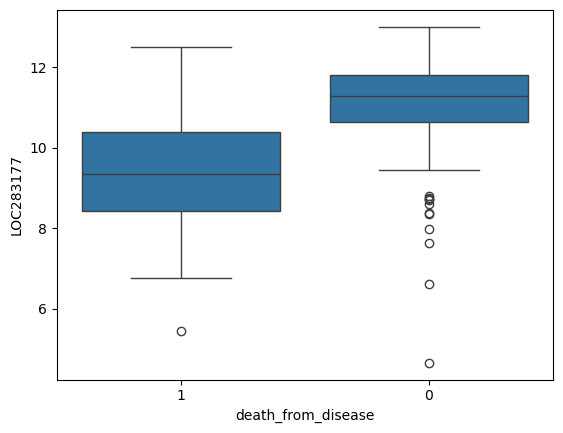

In [170]:
sns.boxplot(data=expr_tr, x='death_from_disease', y="LOC283177")

In [ ]:
# per-gene average log2 expression
mean1 = grp1.mean(axis=0)
mean2 = grp2.mean(axis=0)

# logFC
logFC = mean1 - mean2
logFC.head(4)

In [ ]:
logFC_df = pd.DataFrame(logFC, columns=['logFC']).reset_index().rename(columns={'index': 'Gene'})

In [ ]:
results_df = results_srt.merge(logFC_df)
results_df["-log10P"] = -np.log10(results_df["Adjusted p-value"])
results_df.head(4)

In [ ]:
# simple Volcano plot
ax = sns.scatterplot(
    data=results_df,
    x="logFC",
    y="-log10P",
    alpha=0.6,
    legend=None,
)

In [ ]:
# machine learning analysis
# set up a ML analysis workflow
# train a few models, such as LogisticRegression, SVC with linear kernel, Random Forest and HistBasedGradBoost
# (optional) tune the parameters
# choose a classifier that also natively performs feature ranking and pick the top 10 genes
# make boxplots for them, breaking down by "death_from_disease" values

In [171]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, matthews_corrcoef, roc_auc_score, confusion_matrix, classification_report

In [172]:
target = np.array(clin['death_from_disease'].values, dtype=int)
target

array([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [173]:
data

,ALB,CD24L4.1,RPS11,RPS18,C5orf13,CCT2,COL1A1,DDX1,EEF1A1,FLT3LG_,...,USP17L5,USP17L7,USP17L8,VTRNA2,WFDC11,WFDC9,XAGE2,XAGE2B,ZFATAS,ZP4
title,,,,,,,,,,,,,,,,,,,,,
SEQC_NB001,9.29,18.82,21.17,20.90,20.02,16.31,18.60,15.73,21.71,20.02,...,0.0,0.0,0.0,0.0,4.74,0.0,0.0,0.0,0.0,0.0
SEQC_NB003,9.25,20.25,22.44,22.00,21.05,17.06,19.39,22.84,22.72,21.26,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
SEQC_NB005,8.99,20.09,22.09,21.71,21.65,16.85,23.02,15.79,22.24,20.75,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
SEQC_NB007,8.15,19.75,21.00,20.88,21.48,16.45,20.58,16.09,22.07,20.06,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
SEQC_NB009,10.72,19.66,21.43,21.63,21.81,17.28,19.65,15.90,22.59,20.11,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQC_NB489,9.89,19.99,22.98,22.28,21.55,17.00,17.46,22.83,22.93,21.40,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
SEQC_NB491,7.73,18.94,21.14,20.93,20.57,17.08,16.94,15.81,21.73,20.20,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
SEQC_NB493,8.47,20.75,20.08,20.71,22.16,16.63,17.11,15.93,22.09,19.11,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


In [174]:
X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.30, stratify=target, random_state=78
)

In [175]:
print(X_train.shape)
print(X_test.shape)

(172, 22674)
(74, 22674)


In [176]:
print(y_train.shape)
print(y_test.shape)

(172,)
(74,)


In [177]:
# exploratory analysis and plot: PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

In [179]:
pca.explained_variance_ratio_

array([0.10506946, 0.0592171 ])

In [180]:
%matplotlib inline
import matplotlib.pyplot as plt

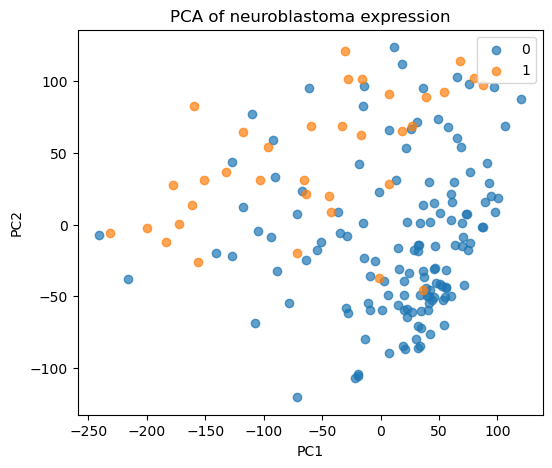

In [181]:
plt.figure(figsize=(6, 5))
for lbl in [0, 1]:
    idx = np.where(y_train == lbl)
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        label=("0" if lbl == 0 else "1"),
        alpha=0.7,
    )
plt.legend()
plt.title(f"PCA of neuroblastoma expression")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [182]:
model = make_pipeline(StandardScaler(), SVC())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_score = model.decision_function(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("MCC:", matthews_corrcoef(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_score))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8513513513513513
MCC: 0.4739760677385579
ROC AUC: 0.880225988700565
Confusion Matrix:
 [[57  2]
 [ 9  6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.97      0.91        59
           1       0.75      0.40      0.52        15

    accuracy                           0.85        74
   macro avg       0.81      0.68      0.72        74
weighted avg       0.84      0.85      0.83        74



In [183]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

model = make_pipeline(StandardScaler(), SVC())
cv = StratifiedKFold(n_splits=5)
cv_result = cross_validate(model, X_train, y_train, cv=cv, scoring=make_scorer(matthews_corrcoef))
cv_result

{'fit_time': array([1.18015289, 1.12253499, 1.2024281 , 1.20628715, 1.17958593]),
 'score_time': array([0.31361604, 0.31340408, 0.32019782, 0.31800604, 0.31905293]),
 'test_score': array([-0.12309149, -0.08574929,  0.        ,  0.        ,  0.        ])}

In [184]:
from sklearn.model_selection import GridSearchCV

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("classifier", SVC(kernel="linear")),
    ]
)

param_grid = {"classifier__C": (0.001, 0.01, 0.1, 1, 10, 100, 1000)}
model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=cv, scoring=make_scorer(matthews_corrcoef))
model_grid_search.fit(X_train, y_train)

,estimator,Pipeline(step...l='linear'))])
,param_grid,"{'classifier__C': (0.001, ...)}"
,scoring,make_scorer(m...hod='predict')
,n_jobs,2
,refit,True
,cv,StratifiedKFo...shuffle=False)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [185]:
model_grid_search.best_params_

{'classifier__C': 0.001}

In [186]:
pd.DataFrame(model_grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.643134,0.018344,0.127197,0.005942,0.001,{'classifier__C': 0.001},0.686406,-0.153093,0.574966,0.098055,0.718331,0.384933,0.349263,1
1,0.638538,0.075810,0.130450,0.007103,0.010,{'classifier__C': 0.01},0.686406,-0.153093,0.574966,0.098055,0.718331,0.384933,0.349263,1
2,0.605587,0.006956,0.128289,0.006189,0.100,{'classifier__C': 0.1},0.686406,-0.153093,0.574966,0.098055,0.718331,0.384933,0.349263,1
3,0.610965,0.011254,0.129914,0.007488,1.000,{'classifier__C': 1},0.686406,-0.153093,0.574966,0.098055,0.718331,0.384933,0.349263,1
4,0.588456,0.014773,0.121142,0.004669,10.000,{'classifier__C': 10},0.686406,-0.153093,0.574966,0.098055,0.718331,0.384933,0.349263,1
5,0.583108,0.029315,0.121237,0.005195,100.000,{'classifier__C': 100},0.686406,-0.153093,0.574966,0.098055,0.718331,0.384933,0.349263,1
6,0.569477,0.051656,0.115170,0.011490,1000.000,{'classifier__C': 1000},0.686406,-0.153093,0.574966,0.098055,0.718331,0.384933,0.349263,1


In [187]:
y_pred = model_grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.8378378378378378

In [188]:
matthews_corrcoef(y_test, y_pred)

0.5237309202575556

In [189]:
# get top ranked genes from the model
best_pipe = model_grid_search.best_estimator_
clf = best_pipe.named_steps['classifier']
coefs = clf.coef_.ravel()
importances = np.abs(coefs)

In [ ]:
# interpretation:
# If the classification model natively ranks the genes, get the top 10-ish ranked genes
# make boxplots for them, breaking down by "death_from_disease" values

In [190]:
idx_sorted = np.argsort(importances)[::-1]

top_n = 10

feature_names = X_train.columns
top_features = [(feature_names[i], importances[i]) for i in idx_sorted[:top_n]]

print(f"Top {top_n} features by linear SVC:")
for name, imp in top_features:
    print(f"  {name:>20s} : {imp:.4f}")

Top 10 features by linear SVC:
                OR6C70 : 0.0028
               SNORD52 : 0.0026
                  GSX1 : 0.0025
             LOC646862 : 0.0024
              DDX11L10 : 0.0024
                 FOXI1 : 0.0023
          LOC100288520 : 0.0023
                 OR1L4 : 0.0023
                NKX2-6 : 0.0023
             KRTAP10-6 : 0.0021


In [ ]:
# boxplots, etc.

In [ ]:
# interpretation:
# use the top gene lists to conduct a pathway enrichment analysis
# investigate the resulting pathways

In [191]:
import gseapy as gp

# using here the top genes from statistical testing
degs = results_srt["Gene"][:200].values.tolist()

In [192]:
enr_Reactome_up = gp.enrichr(gene_list=degs,
                             gene_sets=['Reactome_2022'],
                             organism='Human', 
                             outdir='out/enr_DEGs_Reactome',
                             # cutoff=0.05
                            )

In [193]:
enr_Reactome_up.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Reactome_2022,Cell Cycle R-HSA-1640170,47/654,4.345025e-27,2.628740e-24,0,0,9.713161,589.596330,FEN1;BLM;ERCC6L;CDCA5;DSCC1;HJURP;NCAPG;BUB1B;...
1,Reactome_2022,"Cell Cycle, Mitotic R-HSA-69278",40/523,4.985559e-24,1.508132e-21,0,0,9.998447,536.471651,FEN1;ERCC6L;CDCA5;NCAPG;BUB1B;MCM10;TYMS;SMC4;...
2,Reactome_2022,Resolution Of Sister Chromatid Cohesion R-HSA-...,21/106,1.304145e-21,2.630027e-19,0,0,27.210976,1308.541523,ERCC6L;CDCA5;PLK1;BUB1B;CENPA;NDC80;CCNB2;CENP...
3,Reactome_2022,Mitotic Prometaphase R-HSA-68877,25/186,3.522179e-21,5.327295e-19,0,0,17.425909,820.676818,ERCC6L;CDCA5;BUB1B;NCAPG;SMC4;CENPA;CCNB2;CCNB...
4,Reactome_2022,Cell Cycle Checkpoints R-HSA-69620,27/271,2.440822e-19,2.953395e-17,0,0,12.508576,536.077304,BLM;ERCC6L;BUB1B;MCM10;CENPA;CCNB2;BRIP1;CCNB1...


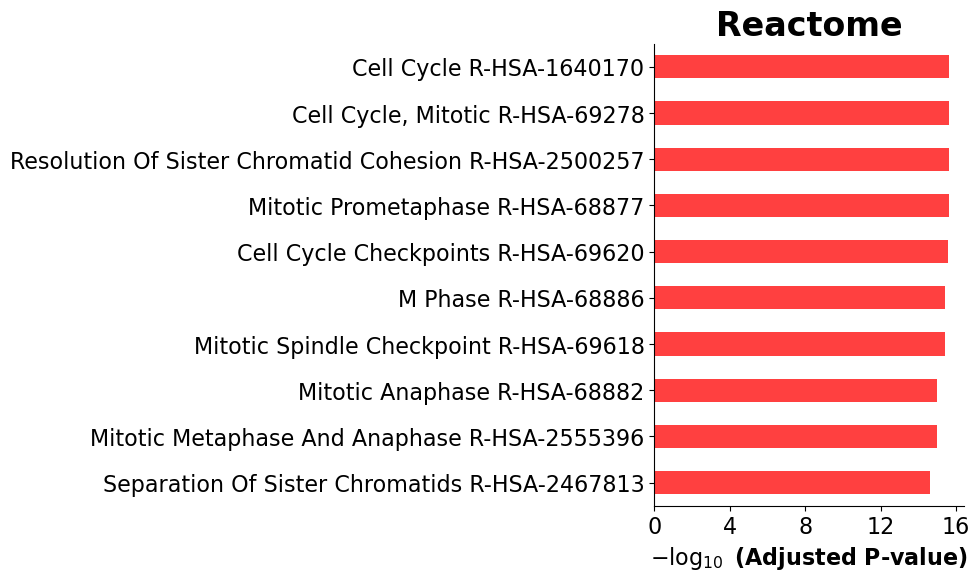

In [194]:
from gseapy.plot import barplot, dotplot

barplot(enr_Reactome_up.res2d, title='Reactome', color='r');